# Crypto Price Prediction

In [1]:
import time
import requests
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as web
from bs4 import BeautifulSoup
from jupyterthemes import jtplot
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

## Web Scraping

In [2]:
names=[]
prices=[]
changes=[]
percentChanges=[]
marketCaps=[]
totalVolumes=[]
circulatingSupplys=[]

In [4]:
CryptoCurrenciesUrl = "https://finance.yahoo.com/cryptocurrencies"
r= requests.get(CryptoCurrenciesUrl)
data=r.text
soup=BeautifulSoup(data)

In [5]:
for listing in soup.find_all('tr', attrs={'class':'simpTblRow'}):
  for name in listing.find_all('td', attrs={'aria-label':'Name'}):
    names.append(name.text)
  for price in listing.find_all('td', attrs={'aria-label':'Price (Intraday)'}):
    prices.append(price.find('span').text)
  for change in listing.find_all('td', attrs={'aria-label':'Change'}):
    changes.append(change.text)
  for percentChange in listing.find_all('td', attrs={'aria-label':'% Change'}):
    percentChanges.append(percentChange.text)
  for marketCap in listing.find_all('td', attrs={'aria-label':'Market Cap'}):
    marketCaps.append(marketCap.text)
  for totalVolume in listing.find_all('td', attrs={'aria-label':'Total Volume All Currencies (24Hr)'}):
    totalVolumes.append(totalVolume.text)
  for circulatingSupply in listing.find_all('td', attrs={'aria-label':'Circulating Supply'}):
    circulatingSupplys.append(circulatingSupply.text)
df_data=pd.DataFrame({"Names": names, "Prices": prices, "Change": changes, "% Change": percentChanges, "Market Cap": marketCaps, "Average Volume": totalVolumes,"Volume":circulatingSupplys})
df_data.index=df_data.index+1
df = df_data.head(12)

df = df.style.set_properties(subset=["Prices", "Change", "% Change", "Market Cap", "Average Volume", "Volume"], **{'text-align': 'right'})
df = df.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])
df

,Names,Prices,Change,% Change,Market Cap,Average Volume,Volume
1,Bitcoin USD,"33,702.02",+276.03,+0.83%,632.008B,25.287B,18.753M
2,Ethereum USD,"2,103.32",-36.93,-1.73%,245.324B,20.265B,116.637M
3,Tether USD,1.0001,+0.0002,+0.02%,62.215B,42.381B,62.207B
4,BinanceCoin USD,313.01,-0.54,-0.17%,48.025B,1.226B,153.433M
5,Cardano USD,1.3237,-0.0269,-1.99%,42.288B,1.147B,31.946B
6,XRP USD,0.621293,-0.007918,-1.26%,28.686B,1.945B,46.172B
7,Dogecoin USD,0.214931,-0.008040,-3.61%,28.02B,1.377B,130.369B
8,USDCoin USD,1.0002,+0.0001,+0.01%,26.09B,1.775B,26.084B
9,Polkadot USD,15.27,-0.26,-1.69%,14.644B,764.218M,959.23M
10,HEX USD,0.083570,+0.005527,+7.08%,14.492B,47.565M,173.411B


### Sort Data by % Change

In [6]:
df_sort = df_data.head(12)
df = df_sort.sort_values("% Change")
df = df.style.set_properties(subset=["Prices", "Change", "% Change", "Market Cap", "Average Volume", "Volume"], **{'text-align': 'right'})
df

,Names,Prices,Change,% Change,Market Cap,Average Volume,Volume
8,USDCoin USD,1.0002,+0.0001,+0.01%,26.09B,1.775B,26.084B
3,Tether USD,1.0001,+0.0002,+0.02%,62.215B,42.381B,62.207B
1,Bitcoin USD,"33,702.02",+276.03,+0.83%,632.008B,25.287B,18.753M
10,HEX USD,0.083570,+0.005527,+7.08%,14.492B,47.565M,173.411B
4,BinanceCoin USD,313.01,-0.54,-0.17%,48.025B,1.226B,153.433M
6,XRP USD,0.621293,-0.007918,-1.26%,28.686B,1.945B,46.172B
12,BitcoinCash USD,491.35,-7.92,-1.59%,9.23B,1.179B,18.786M
9,Polkadot USD,15.27,-0.26,-1.69%,14.644B,764.218M,959.23M
2,Ethereum USD,"2,103.32",-36.93,-1.73%,245.324B,20.265B,116.637M
5,Cardano USD,1.3237,-0.0269,-1.99%,42.288B,1.147B,31.946B


### Prepare Data

In [2]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
crypto_currency = 'BTC'
against_currency = 'USD'

start = dt.datetime(2016,1,1)
end = dt.datetime(2019,12,31)

#data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)
data = pdr.get_data_yahoo(f'{crypto_currency}-{against_currency}', start, end)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,425.875000,432.920990,418.734985,430.566986,430.566986,45996600
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
...,...,...,...,...,...,...
2019-12-26,7274.799316,7388.302734,7200.386719,7238.966797,7238.966797,22787010034
2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360996
2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026


In [3]:
prediction_days = 60

x_train, y_train = [], []
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Create Neural Network

In [7]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_absolute_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
44/44 [==============================] - 12s 109ms/step - loss: 0.0761
Epoch 2/25
44/44 [==============================] - 5s 104ms/step - loss: 0.0366
Epoch 3/25
44/44 [==============================] - 5s 109ms/step - loss: 0.0339
Epoch 4/25
44/44 [==============================] - 5s 106ms/step - loss: 0.0339
Epoch 5/25
44/44 [==============================] - 5s 118ms/step - loss: 0.0332
Epoch 6/25
44/44 [==============================] - 5s 113ms/step - loss: 0.0326
Epoch 7/25
44/44 [==============================] - 5s 109ms/step - loss: 0.0290
Epoch 8/25
44/44 [==============================] - 5s 108ms/step - loss: 0.0289
Epoch 9/25
44/44 [==============================] - 4s 101ms/step - loss: 0.0287
Epoch 10/25
44/44 [==============================] - 5s 104ms/step - loss: 0.0282
Epoch 11/25
44/44 [==============================] - 5s 105ms/step - loss: 0.0259
Epoch 12/25
44/44 [==============================] - 5s 107ms/step - loss: 0.0258
Epoch 13/25
44/44 [=====

### Testing The Model

In [9]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

#test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
test_data = pdr.get_data_yahoo(f'{crypto_currency}-{against_currency}', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)
test_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,7294.438965,7335.290039,7169.777832,7193.599121,7193.599121,21167946112
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
...,...,...,...,...,...,...
2021-07-12,34254.015625,34592.156250,32697.308594,33155.847656,33155.847656,24321499537
2021-07-13,33125.468750,33327.101562,32261.419922,32702.025391,32702.025391,19120856669
2021-07-14,32723.845703,33061.398438,31639.125000,32822.347656,32822.347656,21376531210


In [10]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)
prediction_prices

array([[ 7318.886 ],
       [ 7310.268 ],
       [ 7292.6113],
       [ 7255.6865],
       [ 7227.2324],
       [ 7221.6387],
       [ 7238.225 ],
       [ 7293.3174],
       [ 7405.385 ],
       [ 7552.5874],
       [ 7693.489 ],
       [ 7824.622 ],
       [ 7930.1064],
       [ 8014.5967],
       [ 8076.7065],
       [ 8164.55  ],
       [ 8281.391 ],
       [ 8406.435 ],
       [ 8535.518 ],
       [ 8658.366 ],
       [ 8748.292 ],
       [ 8795.553 ],
       [ 8811.791 ],
       [ 8804.5205],
       [ 8764.771 ],
       [ 8704.035 ],
       [ 8631.442 ],
       [ 8574.396 ],
       [ 8564.018 ],
       [ 8630.445 ],
       [ 8755.985 ],
       [ 8922.5   ],
       [ 9089.408 ],
       [ 9233.354 ],
       [ 9339.065 ],
       [ 9400.935 ],
       [ 9417.124 ],
       [ 9429.142 ],
       [ 9460.311 ],
       [ 9515.977 ],
       [ 9592.191 ],
       [ 9694.431 ],
       [ 9791.714 ],
       [ 9892.841 ],
       [10001.344 ],
       [10100.715 ],
       [10187.762 ],
       [10228

### Visualization

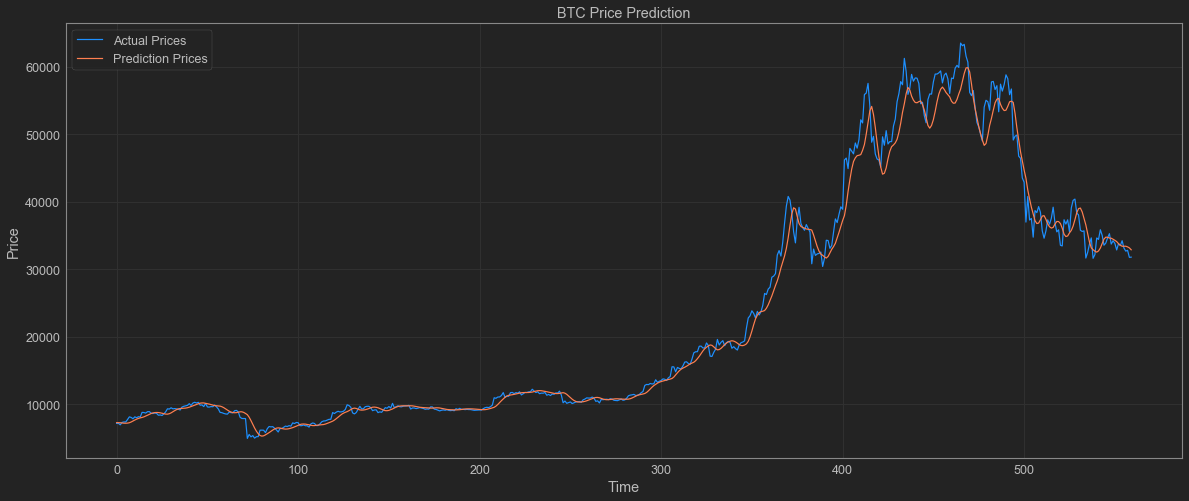

In [11]:
jtplot.style(theme='monokai', figsize=(25, 10))
plt.plot(actual_prices, color='dodgerblue', label='Actual Prices')
plt.plot(prediction_prices, color='coral', label='Prediction Prices')
plt.title(f'{crypto_currency} Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.savefig('price-prediction.png')
plt.show()

### Accuracy

In [12]:
prediction_prices = np.around(np.concatenate(prediction_prices), decimals=8)
actual_prices = np.around(actual_prices, decimals=8)

acc = 1 - np.mean(np.abs((actual_prices - prediction_prices) / actual_prices))
acc = np.around(acc*100, decimals=3)
n = len(actual_prices)
mae = sum(np.abs(actual_prices - prediction_prices))/n
mae = np.around(mae, decimals=3)
rmse = np.sqrt(mean_squared_error(actual_prices, prediction_prices))
rmse = np.around(rmse, decimals=3)

print(f"{crypto_currency}") 
print(f"Accuracy：{acc}%")
print(f"MAE: {mae} USD")
print(f"RMSE: {rmse}")

BTC
Accuracy：95.061%
MAE: 1207.622 USD
RMSE: 1968.308


## Predict Next Day

In [13]:
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
    
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)

print(f"Prediction: {prediction}")

Prediction: [[32555.365]]


## Send a Line Message

In [14]:
counterLine=0 #存送次數
countError=0 #儲存錯誤次數

print('程式開始執行!')

while True:
        if float(prediction):
            print(f"比特幣預測價格: {prediction}")
            counterLine = counterLine + 1
            url_ifttt ='https://maker.ifttt.com/trigger/Line/with/key/dHiZWQoMRhP6rLaygslOIk?value1='+str(prediction) 
            
            res1 = requests.get(url_ifttt) #發送請求
            print('第'+ str(counterLine)+'次發送LINE回傳訊息:' + res1.text)
        if counterLine >=1:#最多發送3次就結束程式
            print('程式結束!')
            break
        for i in range(10):
            time.sleep(10) #每10秒讀一次 

程式開始執行!
比特幣預測價格: [[32555.365]]
第1次發送LINE回傳訊息:Congratulations! You've fired the Line event
程式結束!


# Day of the Week Strategy

### Daily Percentage Change

[*********************100%***********************]  1 of 1 completed


C:\Users\Leo\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


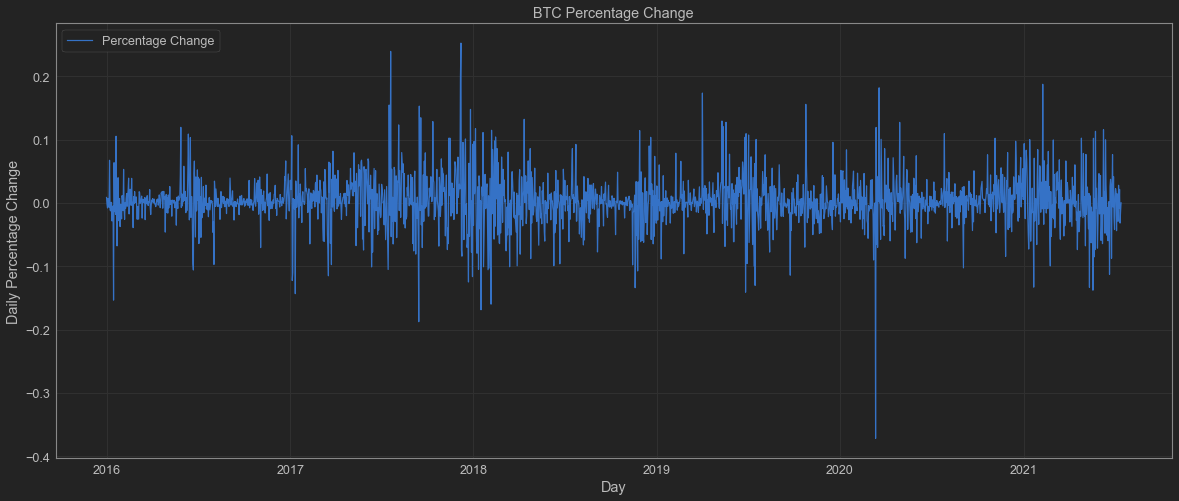

In [10]:
per_start = dt.datetime(2016,1,1)
per_end = dt.datetime.now()
#per_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', per_start, per_end)
per_data = pdr.get_data_yahoo(f'{crypto_currency}-{against_currency}', per_start, per_end)
df = pd.DataFrame(per_data)
df['pct'] = df['Close'].pct_change()

jtplot.style(theme='monokai', figsize=(25, 10))
plt.plot(df['pct'], label='Percentage Change')
plt.title(f'{crypto_currency} Percentage Change')
plt.xlabel('Day')
plt.ylabel('Daily Percentage Change')
plt.legend(loc='upper left')
plt.show()

In [11]:
#將第一筆資料刪除，因為沒有報酬率
df=df.drop(df.index[[0]])
#將報酬率>=0設為1，報酬率<0設為0
target = []
for i in range(len(df)):
    if df["pct"][i]>=0 :
        target.append(1)
    elif df["pct"][i]<0 :
        target.append(0)
df["target"] = target
df

,Open,High,Low,Close,Adj Close,Volume,pct,target
Date,,,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900,0.008749,1
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600,-0.002063,0
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800,-0.007907,0
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500,0.007163,1
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600,-0.002611,0
...,...,...,...,...,...,...,...,...
2021-07-10,33811.242188,34209.070312,33116.011719,33520.519531,33520.519531,22971873468,-0.008210,0
2021-07-11,33509.078125,34584.703125,33346.738281,34240.187500,34240.187500,20108729370,0.021469,1
2021-07-12,34254.015625,34592.156250,32697.308594,33155.847656,33155.847656,24321499537,-0.031669,0


### Sharpe Ratio

In [12]:
df['day'] = pd.to_datetime(df.index)
df['day'] = df['day'].dt.day_name()
df['day'] =  pd.DataFrame(df['day'])
df = df.set_index('day')
df

,Open,High,Low,Close,Adj Close,Volume,pct,target
day,,,,,,,,
Friday,430.721008,436.246002,427.515015,434.334015,434.334015,36278900,0.008749,1
Saturday,434.622009,436.062012,431.869995,433.437988,433.437988,30096600,-0.002063,0
Sunday,433.578003,433.743011,424.705994,430.010986,430.010986,39633800,-0.007907,0
Monday,430.061005,434.516998,429.084015,433.091003,433.091003,38477500,0.007163,1
Tuesday,433.069000,434.182007,429.675995,431.959991,431.959991,34522600,-0.002611,0
...,...,...,...,...,...,...,...,...
Saturday,33811.242188,34209.070312,33116.011719,33520.519531,33520.519531,22971873468,-0.008210,0
Sunday,33509.078125,34584.703125,33346.738281,34240.187500,34240.187500,20108729370,0.021469,1
Monday,34254.015625,34592.156250,32697.308594,33155.847656,33155.847656,24321499537,-0.031669,0


BTC
The highest day is Monday
Sharpe Ratio 1.4401115401573514


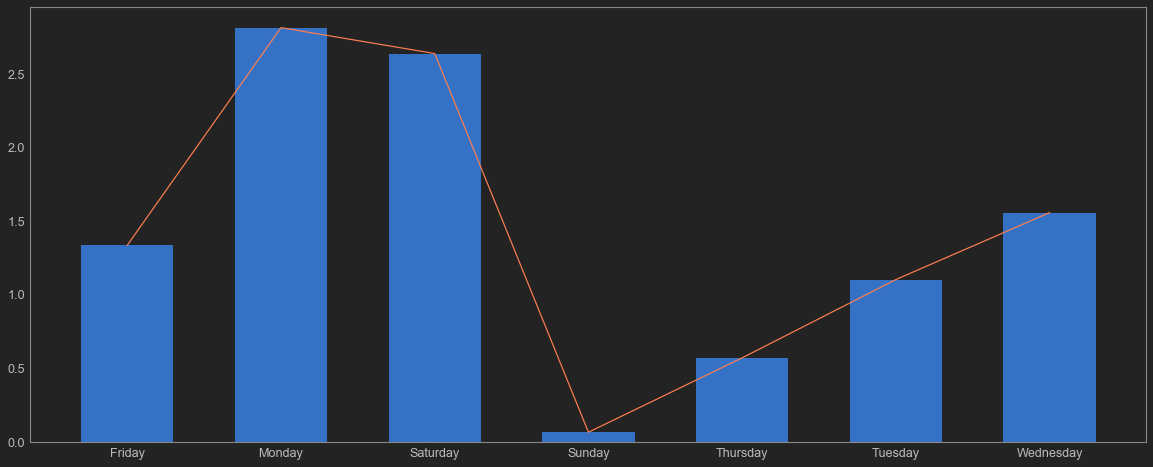

In [13]:
sharpe = np.sqrt(365)*df.groupby(df.index).pct.mean()/df.groupby(df.index).pct.std()
plt.grid(False)
plt.bar(sharpe.index, sharpe.values, width = 0.6)
plt.plot(sharpe, color='coral')
highest_day = sharpe.idxmax()
print(f"{crypto_currency}") 
print("The highest day is", highest_day)
print("Sharpe Ratio", np.mean(sharpe))

## Price Fluctation Prediction

In [ ]:
dff=df[1460:]
dff["prediction_prices"] = prediction_prices
dff['pct_prediction'] = dff['prediction_prices'].pct_change()
#將第一筆資料刪除，因為沒有報酬率
dff=dff.drop(dff.index[[0]])

#將報酬率>=0設為1，報酬率<0設為0
target_prediction = []
for i in range(len(dff)):
    if dff["pct_prediction"][i]>=0 :
        target_prediction.append(1)
    elif dff["pct_prediction"][i]<0 :
        target_prediction.append(0)
dff["target_prediction"] = target_prediction

dff


### Confusion Matrix

In [ ]:
# 混淆矩陣
confusion_matrix(dff["target"], dff['target_prediction'])

### ROC/AUC

In [ ]:
# 計算 ROC 曲線
false_positive_rate, true_positive_rate, thresholds = roc_curve(dff["target"], dff['target_prediction'])

# 計算 AUC 面積
auc(false_positive_rate, true_positive_rate)

## Decision Tree

In [ ]:
# 決定切割比例為 70%:30%
split_point = int(len(df)*0.7)
# 切割成學習樣本以及測試樣本
train = df.iloc[:split_point,:].copy()
test = df.iloc[split_point:-2,:].copy()

# 訓練樣本再分成目標序列 y 以及因子矩陣 X
train_X = train.drop('target', axis = 1)
train_y = train.target
# 測試樣本再分成目標序列 y 以及因子矩陣 X
test_X = test.drop('target', axis = 1)
test_y = test.target

from sklearn.tree import DecisionTreeClassifier

# 叫出一棵決策樹
model = DecisionTreeClassifier(max_depth = 7)

model.fit(train_X, train_y)

# 讓 A.I. 測驗，prediction 存放了 A.I. 根據測試集做出的預測
prediction = model.predict(test_X)

In [ ]:
data1=df[1410:]
data1
data1["prediction"] = prediction
data1

### Confusion Matrix

In [ ]:
confusion_matrix(data1["target"], prediction)

### ROC/AUC

In [ ]:
# 計算 ROC 曲線
false_positive_rate, true_positive_rate, thresholds = roc_curve(data1["target"], prediction)

# 計算 AUC 面積
auc(false_positive_rate, true_positive_rate)